In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import io
import os
import base64
import time
from dotenv import load_dotenv
from collections import OrderedDict
from datetime import date, timedelta
import seaborn as sns

In [2]:
start_date = date(2022, 1, 1)
end_date = date(2024, 8, 8)

current_date = start_date
billboard_dfs = []
while(current_date <= end_date):
    current_csv = f"{current_date.strftime('%Y-%m-%d')}.csv"
    billboard_data = requests.get(f"https://raw.githubusercontent.com/utdata/rwd-billboard-data/main/data-scraped/hot-100/{current_date.year}/{current_csv}").content
    print(f"Fetched {current_csv}")
    
    current_billboard_df = pd.read_csv(io.StringIO(billboard_data.decode("utf-8"))).loc[:9]
    billboard_dfs.append(current_billboard_df)
    current_date += timedelta(days=7)

Fetched 2022-01-01.csv
Fetched 2022-01-08.csv
Fetched 2022-01-15.csv
Fetched 2022-01-22.csv
Fetched 2022-01-29.csv
Fetched 2022-02-05.csv
Fetched 2022-02-12.csv
Fetched 2022-02-19.csv
Fetched 2022-02-26.csv
Fetched 2022-03-05.csv
Fetched 2022-03-12.csv
Fetched 2022-03-19.csv
Fetched 2022-03-26.csv
Fetched 2022-04-02.csv
Fetched 2022-04-09.csv
Fetched 2022-04-16.csv
Fetched 2022-04-23.csv
Fetched 2022-04-30.csv
Fetched 2022-05-07.csv
Fetched 2022-05-14.csv
Fetched 2022-05-21.csv
Fetched 2022-05-28.csv
Fetched 2022-06-04.csv
Fetched 2022-06-11.csv
Fetched 2022-06-18.csv
Fetched 2022-06-25.csv
Fetched 2022-07-02.csv
Fetched 2022-07-09.csv
Fetched 2022-07-16.csv
Fetched 2022-07-23.csv
Fetched 2022-07-30.csv
Fetched 2022-08-06.csv
Fetched 2022-08-13.csv
Fetched 2022-08-20.csv
Fetched 2022-08-27.csv
Fetched 2022-09-03.csv
Fetched 2022-09-10.csv
Fetched 2022-09-17.csv
Fetched 2022-09-24.csv
Fetched 2022-10-01.csv
Fetched 2022-10-08.csv
Fetched 2022-10-15.csv
Fetched 2022-10-22.csv
Fetched 202

In [3]:
billboard_df = pd.concat(billboard_dfs).reset_index()[["chart_week", "current_week", "title", "performer"]]
billboard_df["chart_week"] = pd.to_datetime(billboard_df["chart_week"])
billboard_df

,chart_week,current_week,title,performer
0,2022-01-01,1,All I Want For Christmas Is You,Mariah Carey
1,2022-01-01,2,Rockin' Around The Christmas Tree,Brenda Lee
2,2022-01-01,3,Jingle Bell Rock,Bobby Helms
3,2022-01-01,4,A Holly Jolly Christmas,Burl Ives
4,2022-01-01,5,Easy On Me,Adele
...,...,...,...,...
1355,2024-08-03,6,Too Sweet,Hozier
1356,2024-08-03,7,Please Please Please,Sabrina Carpenter
1357,2024-08-03,8,Lose Control,Teddy Swims
1358,2024-08-03,9,Beautiful Things,Benson Boone


In [4]:
load_dotenv()
client_id = os.getenv("SPOTIFY_CLIENT_ID")
client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")

credentials = f"{client_id}:{client_secret}"
base64_credentials = base64.b64encode(credentials.encode()).decode()

auth_options = {
    "headers": {"Authorization": f"Basic {base64_credentials}"},
    "data": {"grant_type": "client_credentials"}
}
auth_response = requests.post("https://accounts.spotify.com/api/token", headers=auth_options["headers"], data=auth_options["data"]).json()
access_token = auth_response["access_token"]
access_token

'BQAJuPnz4c3gp4c-fEF7GmLpS3JA4CkGc1yY4O7izVXQqzL875qOaU-5m1tRO73UXdWlnLnrS9PdjfT_M36Gh6Mno21R86n4gznQBrEQ4XHA7YNgMvI'

In [5]:
def parse_artist(artist):
    return artist.split("X")[0].split("&")[0].split(",")[0].split("Featuring")[0].strip()

def parse_song_name(name):
    if "*" in name:
        words = name.split(" ")
        replaced_words = []
        for word in words:
            if "*" in word:
                new_word = word[0] + "*" * (len(word) - 1)
                replaced_words.append(new_word)
            else:
                replaced_words.append(word)
        return " ".join(replaced_words)
    return name

In [6]:
track_info = OrderedDict()

def find_track_id(song):
    name = parse_song_name(song["title"])
    artist = parse_artist(song["performer"])

    if((name, artist) not in track_info):
        while True:
            search_response = requests.get(
                "https://api.spotify.com/v1/search",
                headers={"Authorization": f"Bearer {access_token}"},
                params={
                    "q":  f"{name} {artist}",
                    "type": "track",
                    "limit": 1
                }
            )
            if search_response.status_code == 429:
                print("Too many requests. Retrying in 30 seconds...")
                time.sleep(30)
            else:
                try:
                    track_id = search_response.json()["tracks"]["items"][0]["id"]
                    artist_id = search_response.json()["tracks"]["items"][0]["artists"][0]["id"]
                    track_info[(name, artist)] = {"track_id": track_id, "artist_id": artist_id}
                    print(f"Id for '{name}' by '{artist}' is {track_id}")
                except:
                    print(f"Error in '{name}' by '{artist}'")
                    print(search_response.json())
                break

billboard_df.apply(find_track_id, axis=1)
print(f"Total number of track ids found: {len(track_info)}")

Id for 'All I Want For Christmas Is You' by 'Mariah Carey' is 0bYg9bo50gSsH3LtXe2SQn
Id for 'Rockin' Around The Christmas Tree' by 'Brenda Lee' is 2EjXfH91m7f8HiJN1yQg97
Id for 'Jingle Bell Rock' by 'Bobby Helms' is 7vQbuQcyTflfCIOu3Uzzya
Id for 'A Holly Jolly Christmas' by 'Burl Ives' is 77khP2fIVhSW23NwxrRluh
Id for 'Easy On Me' by 'Adele' is 0gplL1WMoJ6iYaPgMCL0gX
Id for 'It's The Most Wonderful Time Of The Year' by 'Andy Williams' is 5hslUAKq9I9CG2bAulFkHN
Id for 'Last Christmas' by 'Wham!' is 2FRnf9qhLbvw8fu4IBXx78
Id for 'Feliz Navidad' by 'Jose Feliciano' is 0oPdaY4dXtc3ZsaG17V972
Id for 'Stay' by 'The Kid LAROI' is 567e29TDzLwZwfDuEpGTwo
Id for 'Sleigh Ride' by 'The Ronettes' is 5ASM6Qjiav2xPe7gRkQMsQ
Id for 'Heat Waves' by 'Glass Animals' is 3USxtqRwSYz57Ewm6wWRMp
Id for 'Shivers' by 'Ed Sheeran' is 50nfwKoDiSYg8zOCREWAm5
Id for 'We Don't Talk About Bruno' by 'Carolina Gaitan' is 52xJxFP6TqMuO4Yt0eOkMz
Id for 'Industry Baby' by 'Lil Nas' is 27NovPIUIRrOZoCHxABJwK
Id for 'Cold 

In [7]:
track_ids = [x["track_id"] for x in track_info.values()]
audio_features = []
for i in range(0, len(track_ids), 100):
    chunk = track_ids[i:i + 100]

    while True:
        audio_features_response = requests.get(
            "https://api.spotify.com/v1/audio-features",
            headers={"Authorization": f"Bearer {access_token}"},
            params={"ids": ",".join(chunk)}
        )
        if audio_features_response.status_code == 429:
            print("Too many requests. Retrying in 30 seconds...")
            time.sleep(30)
        else:
            print(f"Fetched audio features for tracks {i+1} to {i+len(chunk)}")
            audio_features += audio_features_response.json()["audio_features"]
            break

artist_ids = [x["artist_id"] for x in track_info.values()]
genres = []
for i in range(0, len(artist_ids), 50):
    chunk = artist_ids[i:i + 50]

    while True:
        artist_response = requests.get(
            "https://api.spotify.com/v1/artists",
            headers={"Authorization": f"Bearer {access_token}"},
            params={"ids": ",".join(chunk)}
        )
        if artist_response.status_code == 429:
            print("Too many requests. Retrying in 30 seconds...")
            time.sleep(30)
        else:
            print(f"Fetched artists {i+1} to {i+len(chunk)}")
            genres += [x["genres"] for x in artist_response.json()["artists"]]
            break

for i, k in enumerate(track_info.keys()):
    track_info[k] = audio_features[i]
    track_info[k]["genres"] = genres[i]

print(f"Features found: {', '.join(next(iter(track_info.values())).keys())}")

Fetched audio features for tracks 1 to 100
Fetched audio features for tracks 101 to 200
Fetched audio features for tracks 201 to 205
Fetched artists 1 to 50
Fetched artists 51 to 100
Fetched artists 101 to 150
Fetched artists 151 to 200
Fetched artists 201 to 205
Features found: danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, type, id, uri, track_href, analysis_url, duration_ms, time_signature, genres


In [8]:
def add_feature(song, feature):
    name = parse_song_name(song["title"])
    artist = parse_artist(song["performer"])
    return track_info[(name, artist)][feature] if (name, artist) in track_info else None

billboard_df["danceability"] = billboard_df.apply(add_feature, args=("danceability",), axis=1)
billboard_df["energy"] = billboard_df.apply(add_feature, args=("energy",), axis=1)
billboard_df["loudness"] = billboard_df.apply(add_feature, args=("loudness",), axis=1)
billboard_df["speechiness"] = billboard_df.apply(add_feature, args=("speechiness",), axis=1)
billboard_df["acousticness"] = billboard_df.apply(add_feature, args=("acousticness",), axis=1)
billboard_df["liveness"] = billboard_df.apply(add_feature, args=("liveness",), axis=1)
billboard_df["tempo"] = billboard_df.apply(add_feature, args=("tempo",), axis=1)
billboard_df["valence"] = billboard_df.apply(add_feature, args=("valence",), axis=1)
billboard_df["time_signature"] = billboard_df.apply(add_feature, args=("time_signature",), axis=1)
billboard_df["duration_ms"] = billboard_df.apply(add_feature, args=("duration_ms",), axis=1)
billboard_df["genres"] = billboard_df.apply(add_feature, args=("genres",), axis=1)

billboard_df

,chart_week,current_week,title,performer,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,valence,time_signature,duration_ms,genres
0,2022-01-01,1,All I Want For Christmas Is You,Mariah Carey,0.336,0.627,-7.463,0.0384,0.1640,0.0708,150.273,0.350,4,241107,"[dance pop, pop, urban contemporary]"
1,2022-01-01,2,Rockin' Around The Christmas Tree,Brenda Lee,0.598,0.470,-8.744,0.0496,0.6170,0.5050,67.086,0.879,4,126267,"[adult standards, lounge, rockabilly]"
2,2022-01-01,3,Jingle Bell Rock,Bobby Helms,0.754,0.424,-8.463,0.0363,0.6430,0.0652,119.705,0.806,4,130973,[]
3,2022-01-01,4,A Holly Jolly Christmas,Burl Ives,0.682,0.375,-13.056,0.0303,0.5790,0.0760,140.453,0.888,4,135533,"[adult standards, american folk revival]"
4,2022-01-01,5,Easy On Me,Adele,0.604,0.366,-7.519,0.0282,0.5780,0.1330,141.981,0.130,4,224695,"[british soul, pop, pop soul, uk pop]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,2024-08-03,6,Too Sweet,Hozier,0.741,0.620,-5.505,0.0412,0.0295,0.0398,117.038,0.934,4,251424,"[irish singer-songwriter, modern rock, pop, po..."
1356,2024-08-03,7,Please Please Please,Sabrina Carpenter,0.669,0.586,-6.073,0.0540,0.2740,0.1040,107.071,0.579,4,186365,[pop]
1357,2024-08-03,8,Lose Control,Teddy Swims,0.561,0.604,-4.409,0.0337,0.1990,0.1040,159.920,0.242,3,210689,[]
1358,2024-08-03,9,Beautiful Things,Benson Boone,0.472,0.471,-5.692,0.0603,0.1510,0.1400,105.029,0.219,3,180304,[singer-songwriter pop]


In [9]:
billboard_df.to_csv("billboard.csv", index=False)
# billboard_df = pd.read_csv("billboard.csv")
billboard_df["chart_week"] = pd.to_datetime(billboard_df["chart_week"])
billboard_df = billboard_df.rename(columns={"current_week": "rank", "title": "song"})
billboard_df['month_year'] = billboard_df['chart_week'].dt.to_period('M')
billboard_df.head()

,chart_week,rank,song,performer,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,valence,time_signature,duration_ms,genres,month_year
0,2022-01-01,1,All I Want For Christmas Is You,Mariah Carey,0.336,0.627,-7.463,0.0384,0.164,0.0708,150.273,0.350,4,241107,"[dance pop, pop, urban contemporary]",2022-01
1,2022-01-01,2,Rockin' Around The Christmas Tree,Brenda Lee,0.598,0.470,-8.744,0.0496,0.617,0.5050,67.086,0.879,4,126267,"[adult standards, lounge, rockabilly]",2022-01
2,2022-01-01,3,Jingle Bell Rock,Bobby Helms,0.754,0.424,-8.463,0.0363,0.643,0.0652,119.705,0.806,4,130973,[],2022-01
3,2022-01-01,4,A Holly Jolly Christmas,Burl Ives,0.682,0.375,-13.056,0.0303,0.579,0.0760,140.453,0.888,4,135533,"[adult standards, american folk revival]",2022-01
4,2022-01-01,5,Easy On Me,Adele,0.604,0.366,-7.519,0.0282,0.578,0.1330,141.981,0.130,4,224695,"[british soul, pop, pop soul, uk pop]",2022-01


In [11]:
# Data Exploration: Spotify

In [14]:
print(f"Number of weeks: {billboard_df['chart_week'].nunique()}")
print(f"Number of songs: {billboard_df['song'].nunique()}")
print(f"Number of performers: {billboard_df['performer'].nunique()}")

Number of weeks: 136
Number of songs: 204
Number of performers: 132


In [15]:
# Music feature correlations

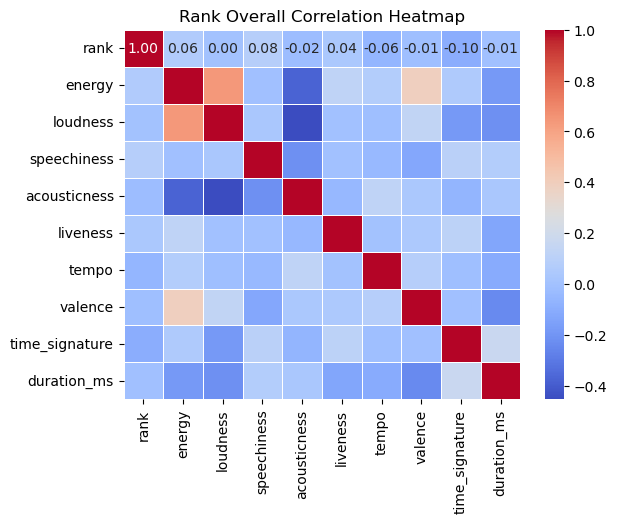

In [17]:
# Understand Relationships between Rank and Attributes
rank_corr_overall= billboard_df[['rank','energy','loudness','speechiness','acousticness','liveness','tempo','valence','time_signature','duration_ms']].corr()
#plt.figure(figsize=(10, 8))  
sns.heatmap(rank_corr_overall, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Rank Overall Correlation Heatmap')
plt.show()

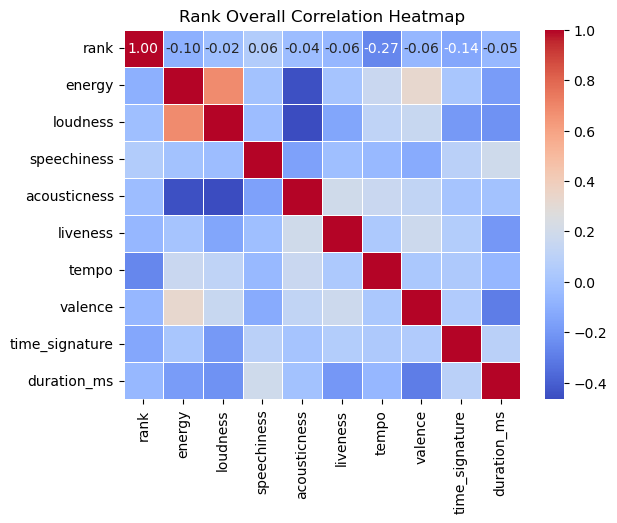

In [18]:
# Does Correlation change for the top 3 songs 
bins = [0, 3, 7, 10]  # Define bin edges
labels = ['1-3', '4-6', '7-10']  # Define labels for the bins
billboard_df['rank_bucket'] = pd.cut(billboard_df['rank'], bins=bins, labels=labels, right=True)

Billboard_top_3 = billboard_df.loc[billboard_df['rank_bucket'] =='1-3']
rank_corr_top3= Billboard_top_3[['rank','energy','loudness','speechiness','acousticness','liveness','tempo','valence','time_signature','duration_ms']].corr()
#plt.figure(figsize=(10, 8))  
sns.heatmap(rank_corr_top3, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Rank Overall Correlation Heatmap')
plt.show()

In [16]:
#Create a Mood Factor using the most correlating variables 
def calculate_mood(row):
    return (row['energy'] * 0.6) + (row['valence'] * 0.4) 

# Apply the custom function
billboard_df['mood'] = billboard_df.apply(calculate_mood, axis=1)

# mean mood rating by month in a year 
Billboard_weekly_mood =billboard_df[['month_year','mood']]
Billboard_monthly_mood = Billboard_weekly_mood.groupby('month_year').mean()
Billboard_monthly_mood.head(10)

,mood
month_year,
2022-01,0.586380
2022-02,0.533190
2022-03,0.579990
2022-04,0.609220
2022-05,0.622190
2022-06,0.593885
2022-07,0.588963
2022-08,0.641940
2022-09,0.689745


In [19]:
# Calculate the correlation matrix
columns_to_convert = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'liveness', 'tempo', 'valence','duration_ms', 'mood', 'rank']
corr_matrix = billboard_df[columns_to_convert].corr()

print(corr_matrix)

              danceability    energy  loudness  speechiness  acousticness  \
danceability      1.000000  0.129517  0.149922     0.122940     -0.354226   
energy            0.129517  1.000000  0.641445    -0.007745     -0.377858   
loudness          0.149922  0.641445  1.000000     0.034219     -0.454107   
speechiness       0.122940 -0.007745  0.034219     1.000000     -0.218253   
acousticness     -0.354226 -0.377858 -0.454107    -0.218253      1.000000   
liveness          0.014294  0.122188 -0.004883    -0.001025     -0.046381   
tempo            -0.397622  0.071840 -0.015084    -0.044586      0.123840   
valence           0.279078  0.387733  0.133100    -0.127175      0.038801   
duration_ms      -0.045330 -0.182441 -0.216870     0.073326      0.033594   
mood              0.251402  0.805767  0.442577    -0.086020     -0.185406   
rank              0.039030  0.060529  0.003651     0.081212     -0.024730   

              liveness     tempo   valence  duration_ms      mood      rank

In [20]:
#Observations "
#There is a relatively high negative correlation between enery/tempo and rank i.e. the top songs generally have high energy( as they have the lowest ranks)"
#While not highly correlated , top ranked songs are generally high in positivity( identified by the negative corelation with valence= positivity)'
#and lower in speechiness (positive correlation i.e. the lower the rank the lesser the speechiness)"

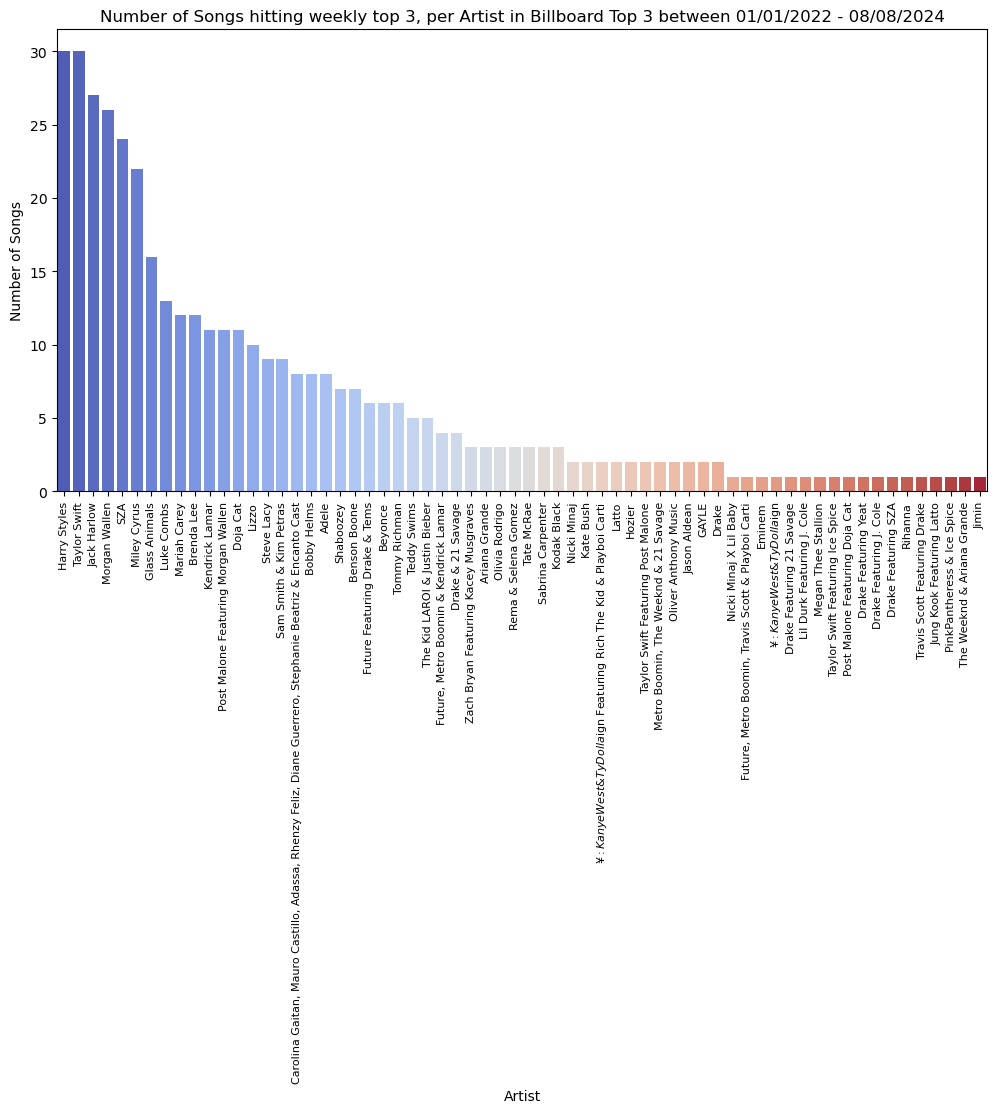

In [21]:
artist_song_counts = Billboard_top_3['performer'].value_counts()
artist_song_counts

# Are certain artists showing up more on the lists compared to others for the top 3 songs?
artist_song_counts = Billboard_top_3['performer'].value_counts()
artist_song_counts
# Convert to DataFrame for easier manipulation
artist_song_counts_df = artist_song_counts.reset_index()
artist_song_counts_df.columns = ['artist', 'number_of_songs']

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='artist', y='number_of_songs', data=artist_song_counts_df, palette='coolwarm')
plt.xlabel('Artist')
plt.ylabel('Number of Songs')
plt.title('Number of Songs hitting weekly top 3, per Artist in Billboard Top 3 between 01/01/2022 - 08/08/2024')
plt.xticks(rotation=90, fontsize=8)
plt.show()

In [22]:
# get the min and max values of the highly correlated values for top 3 songs 
min_values = Billboard_top_3.min(numeric_only=True)
max_values = Billboard_top_3.max(numeric_only=True)
# Creating a DataFrame 
winning_matrix_ranges = pd.DataFrame({
    'Variable': min_values.index,
    'Min Value': min_values.values,
    'Max Value': max_values.values
})
winning_matrix_ranges

,Variable,Min Value,Max Value
0,rank,1.000000,3.0000
1,danceability,0.247000,0.9500
2,energy,0.264000,0.8910
3,loudness,-13.187000,-2.6530
4,speechiness,0.026200,0.4230
5,acousticness,0.000307,0.8990
6,liveness,0.023200,0.5050
7,tempo,67.086000,205.8630
8,valence,0.038400,0.9340
9,time_signature,1.000000,4.0000


In [23]:
# get the min and max values of the highly correlated values for top 100 songs 
min_values_100 = billboard_df.min(numeric_only=True)
max_values_100 = billboard_df.max(numeric_only=True)
# Creating a DataFrame 
winning_matrix_ranges_100 = pd.DataFrame({
    'Variable': min_values_100.index,
    'Min Value': min_values_100.values,
    'Max Value': max_values_100.values
})
winning_matrix_ranges_100

,Variable,Min Value,Max Value
0,rank,1.000000,10.0000
1,danceability,0.240000,0.9500
2,energy,0.192000,0.9650
3,loudness,-15.231000,-2.6530
4,speechiness,0.025500,0.6430
5,acousticness,0.000307,0.9200
6,liveness,0.023200,0.7300
7,tempo,67.086000,205.8630
8,valence,0.038400,0.9630
9,time_signature,1.000000,5.0000


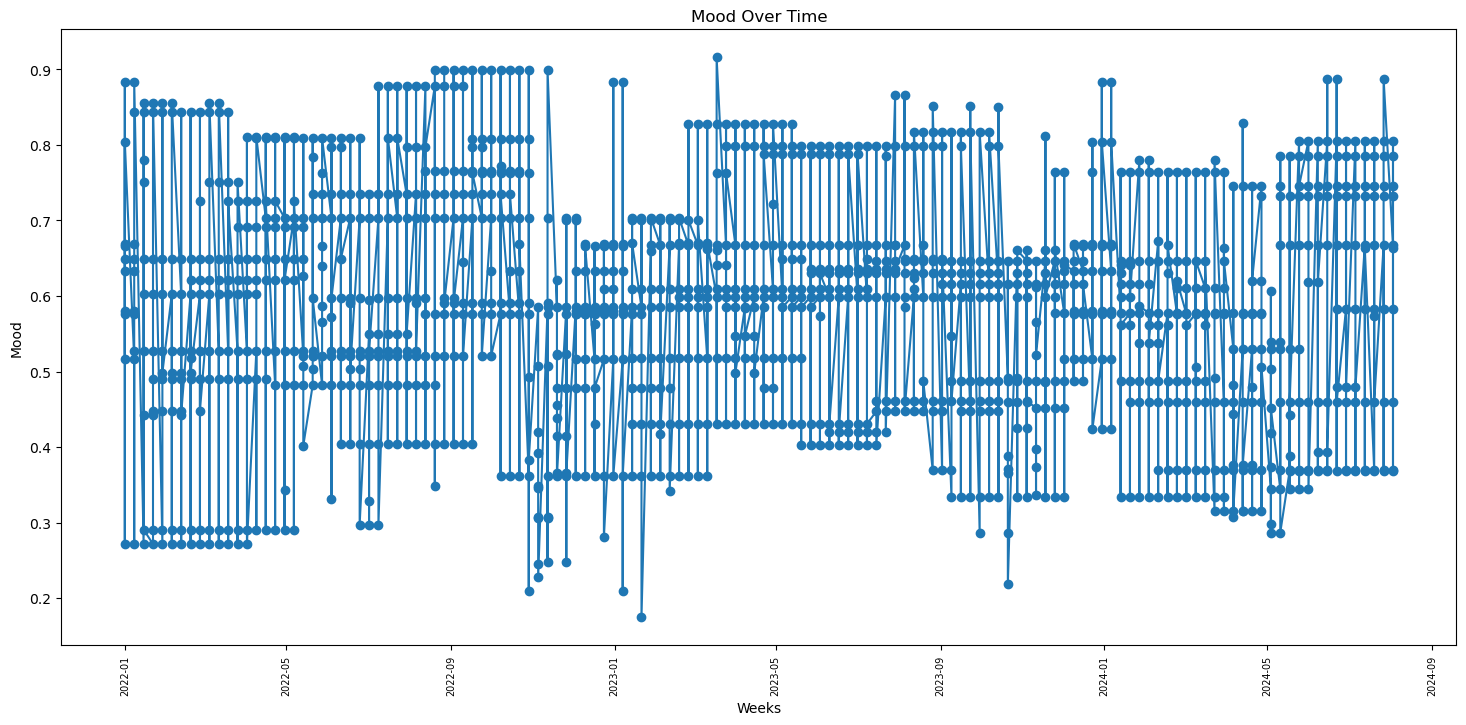

In [24]:
# Plot the mood of the top 100 songs over time 
# Calculate weekly averagean()
plt.figure(figsize=(18, 8))
plt.plot(billboard_df["chart_week"], billboard_df['mood'], marker='o')
plt.xlabel('Weeks')
plt.ylabel('Mood')
plt.title('Mood Over Time')
plt.grid(False)
plt.xticks(rotation=90, fontsize=7)
plt.show()

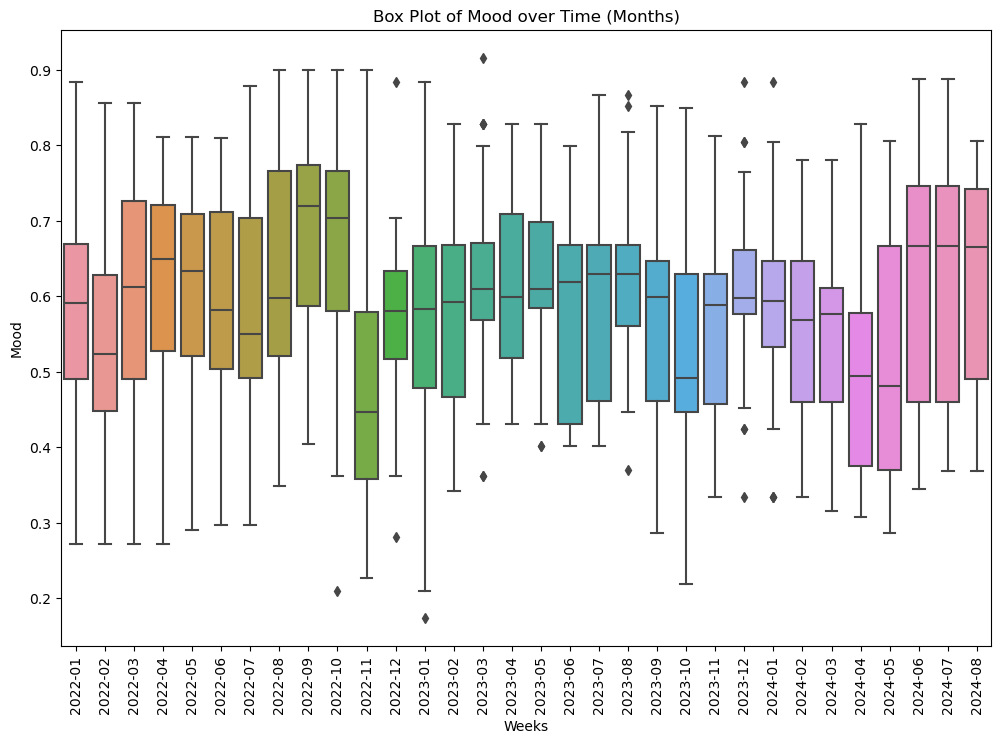

In [25]:
# Box plot for Valence by Rank
plt.figure(figsize=(12, 8))
sns.boxplot(x='month_year', y='mood', data=billboard_df)
plt.xlabel('Weeks')
plt.ylabel('Mood')
plt.xticks(rotation=90)
plt.title('Box Plot of Mood over Time (Months)')

plt.show()

C:\Users\Azlan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Azlan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Azlan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Azlan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

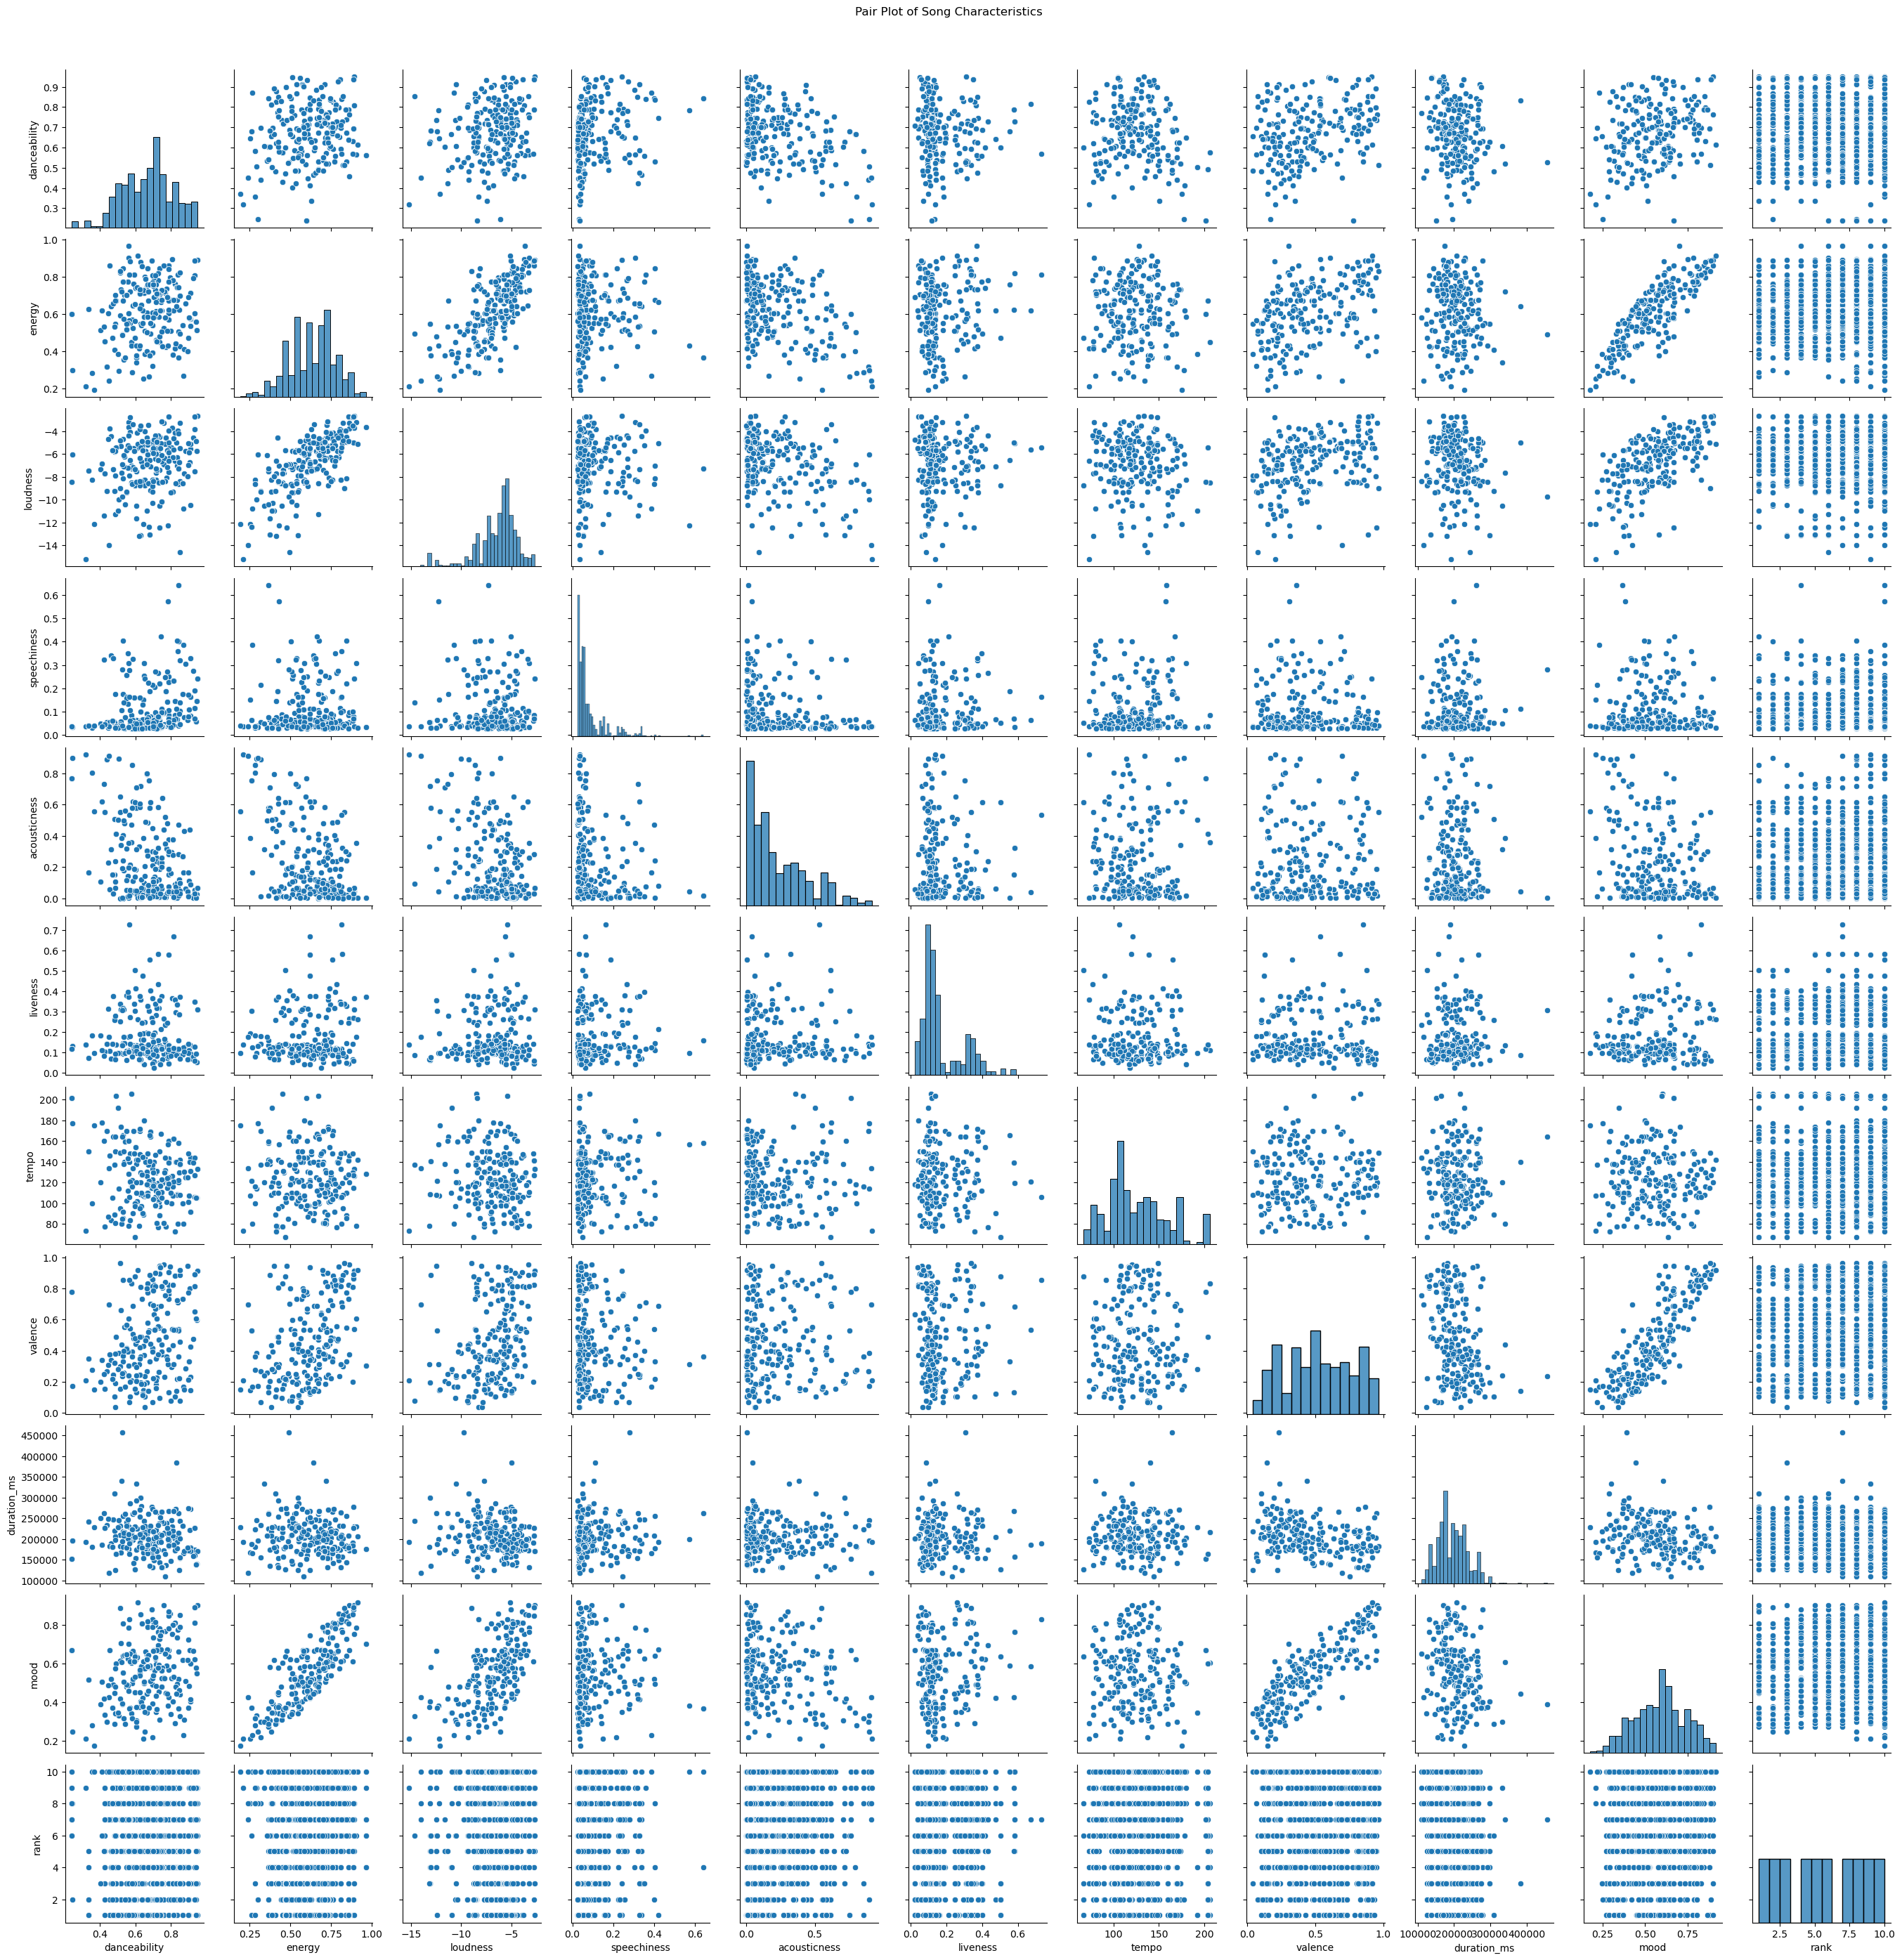

In [27]:
billboard_df[columns_to_convert] = billboard_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

sns.pairplot(billboard_df[columns_to_convert])
plt.suptitle('Pair Plot of Song Characteristics', y=1.02)
plt.show()

In [28]:
gpr_data = requests.get("https://www.matteoiacoviello.com/gpr_files/data_gpr_daily_recent.xls").content

gpr_df = pd.DataFrame(pd.read_excel(io.BytesIO(gpr_data), index_col="date", parse_dates=True)) 
gpr_df = gpr_df.loc["2022-01-01":][["GPRD", "GPRD_THREAT", "GPRD_ACT"]]
gpr_df

,GPRD,GPRD_THREAT,GPRD_ACT
date,,,
2022-01-01,63.096531,91.816795,31.451157
2022-01-02,37.857918,62.960087,0.000000
2022-01-03,52.343060,74.614098,14.909126
2022-01-04,88.963112,139.248215,10.434032
2022-01-05,96.482552,137.534164,82.444771
...,...,...,...
2024-08-08,163.247696,135.745560,189.869400
2024-08-09,158.612823,131.891525,194.614883
2024-08-10,145.836319,138.591385,180.003464


In [33]:
top_dfs = []
for i in range(1, 4):
    top_dfs.append(billboard_df.loc[billboard_df["rank"] == i])
    
top_3_dfs = pd.concat(top_dfs)
top_3_dfs.head()

,chart_week,rank,song,performer,danceability,energy,loudness,speechiness,acousticness,liveness,tempo,valence,time_signature,duration_ms,genres,month_year,mood,rank_bucket
0,2022-01-01,1,All I Want For Christmas Is You,Mariah Carey,0.336,0.627,-7.463,0.0384,0.164,0.0708,150.273,0.35,4,241107,"[dance pop, pop, urban contemporary]",2022-01,0.5162,1-3
10,2022-01-08,1,All I Want For Christmas Is You,Mariah Carey,0.336,0.627,-7.463,0.0384,0.164,0.0708,150.273,0.35,4,241107,"[dance pop, pop, urban contemporary]",2022-01,0.5162,1-3
20,2022-01-15,1,Easy On Me,Adele,0.604,0.366,-7.519,0.0282,0.578,0.1330,141.981,0.13,4,224695,"[british soul, pop, pop soul, uk pop]",2022-01,0.2716,1-3
30,2022-01-22,1,Easy On Me,Adele,0.604,0.366,-7.519,0.0282,0.578,0.1330,141.981,0.13,4,224695,"[british soul, pop, pop soul, uk pop]",2022-01,0.2716,1-3
40,2022-01-29,1,Easy On Me,Adele,0.604,0.366,-7.519,0.0282,0.578,0.1330,141.981,0.13,4,224695,"[british soul, pop, pop soul, uk pop]",2022-01,0.2716,1-3


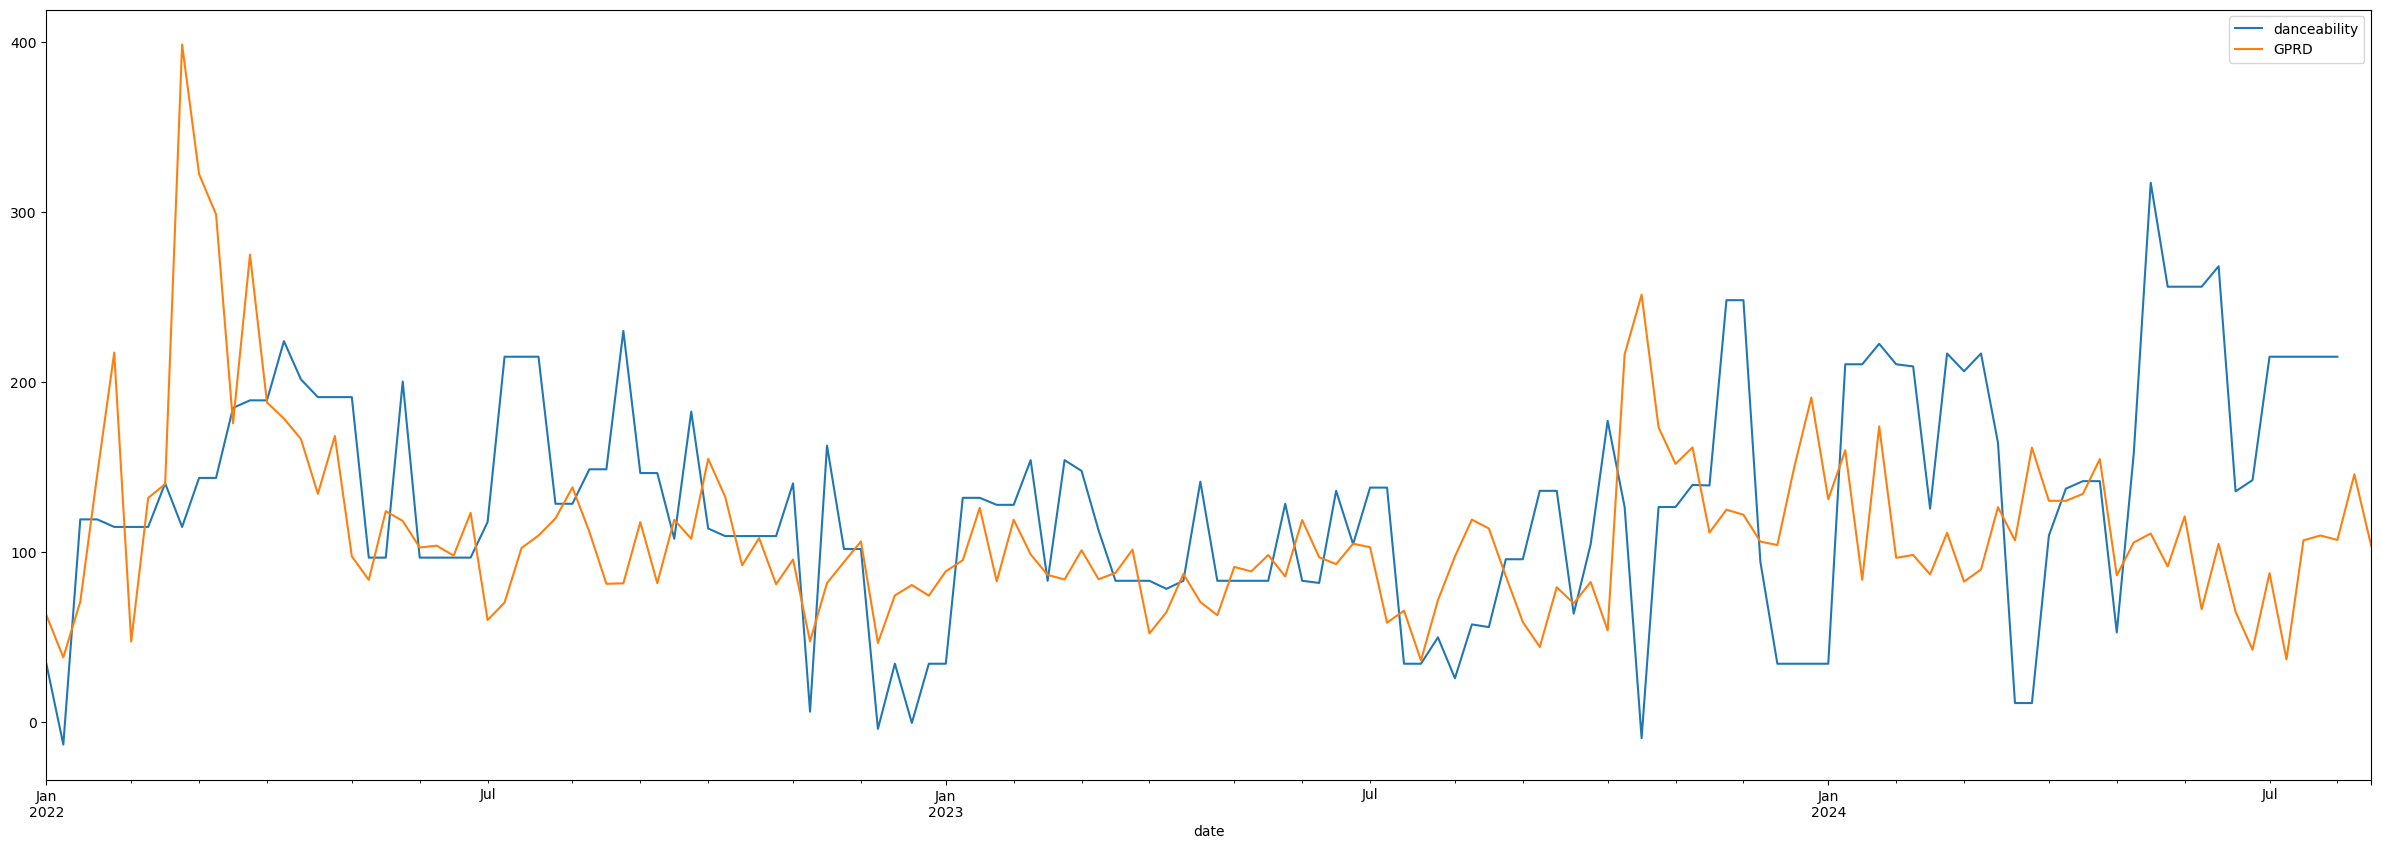

In [34]:
danceability_group = top_3_dfs.groupby("chart_week")["danceability"].mean() * 950 - 500

fig = plt.figure(figsize=(30, 10))
danceability_group.plot()
gpr_df["GPRD"].plot()

plt.legend()
plt.show()

In [35]:
gpr_data = requests.get(f"https://github.com/iacoviel/iacoviel.github.io/raw/master/gpr_archive_files/data_gpr_export_202408.xls").content
monthly_gpr_df = pd.read_excel(io.BytesIO(gpr_data)).set_index("month")["2022-01-01":]
monthly_gpr_df = monthly_gpr_df[['GPR', 'SHARE_GPR', 'GPRT', 'GPRA', 'GPRC_USA', 'GPR_BASIC', 'GPR_NOEW', 'GPR_AND']]
monthly_gpr_df.head()

,GPR,SHARE_GPR,GPRT,GPRA,GPRC_USA,GPR_BASIC,GPR_NOEW,GPR_AND
month,,,,,,,,
2022-01-01,138.674988,4.159395,199.487518,63.251530,3.315881,162.787338,174.142807,135.375610
2022-02-01,216.159012,6.483439,320.605865,105.218307,4.877680,287.502899,270.097809,173.387543
2022-03-01,318.954926,9.566683,403.713623,250.955856,6.899374,405.902893,389.822449,284.315430
2022-04-01,191.143097,5.733116,221.910553,184.417816,3.965940,228.429352,205.864838,172.318939
2022-05-01,142.258484,4.266878,166.424561,140.137344,3.146398,173.042816,160.359512,135.051697


In [36]:
monthly_gpr_df["GPR_USA"] = (monthly_gpr_df["GPRC_USA"] / 100) * monthly_gpr_df["GPR"]
monthly_gpr_df.head()

,GPR,SHARE_GPR,GPRT,GPRA,GPRC_USA,GPR_BASIC,GPR_NOEW,GPR_AND,GPR_USA
month,,,,,,,,,
2022-01-01,138.674988,4.159395,199.487518,63.251530,3.315881,162.787338,174.142807,135.375610,4.598298
2022-02-01,216.159012,6.483439,320.605865,105.218307,4.877680,287.502899,270.097809,173.387543,10.543546
2022-03-01,318.954926,9.566683,403.713623,250.955856,6.899374,405.902893,389.822449,284.315430,22.005893
2022-04-01,191.143097,5.733116,221.910553,184.417816,3.965940,228.429352,205.864838,172.318939,7.580620
2022-05-01,142.258484,4.266878,166.424561,140.137344,3.146398,173.042816,160.359512,135.051697,4.476018


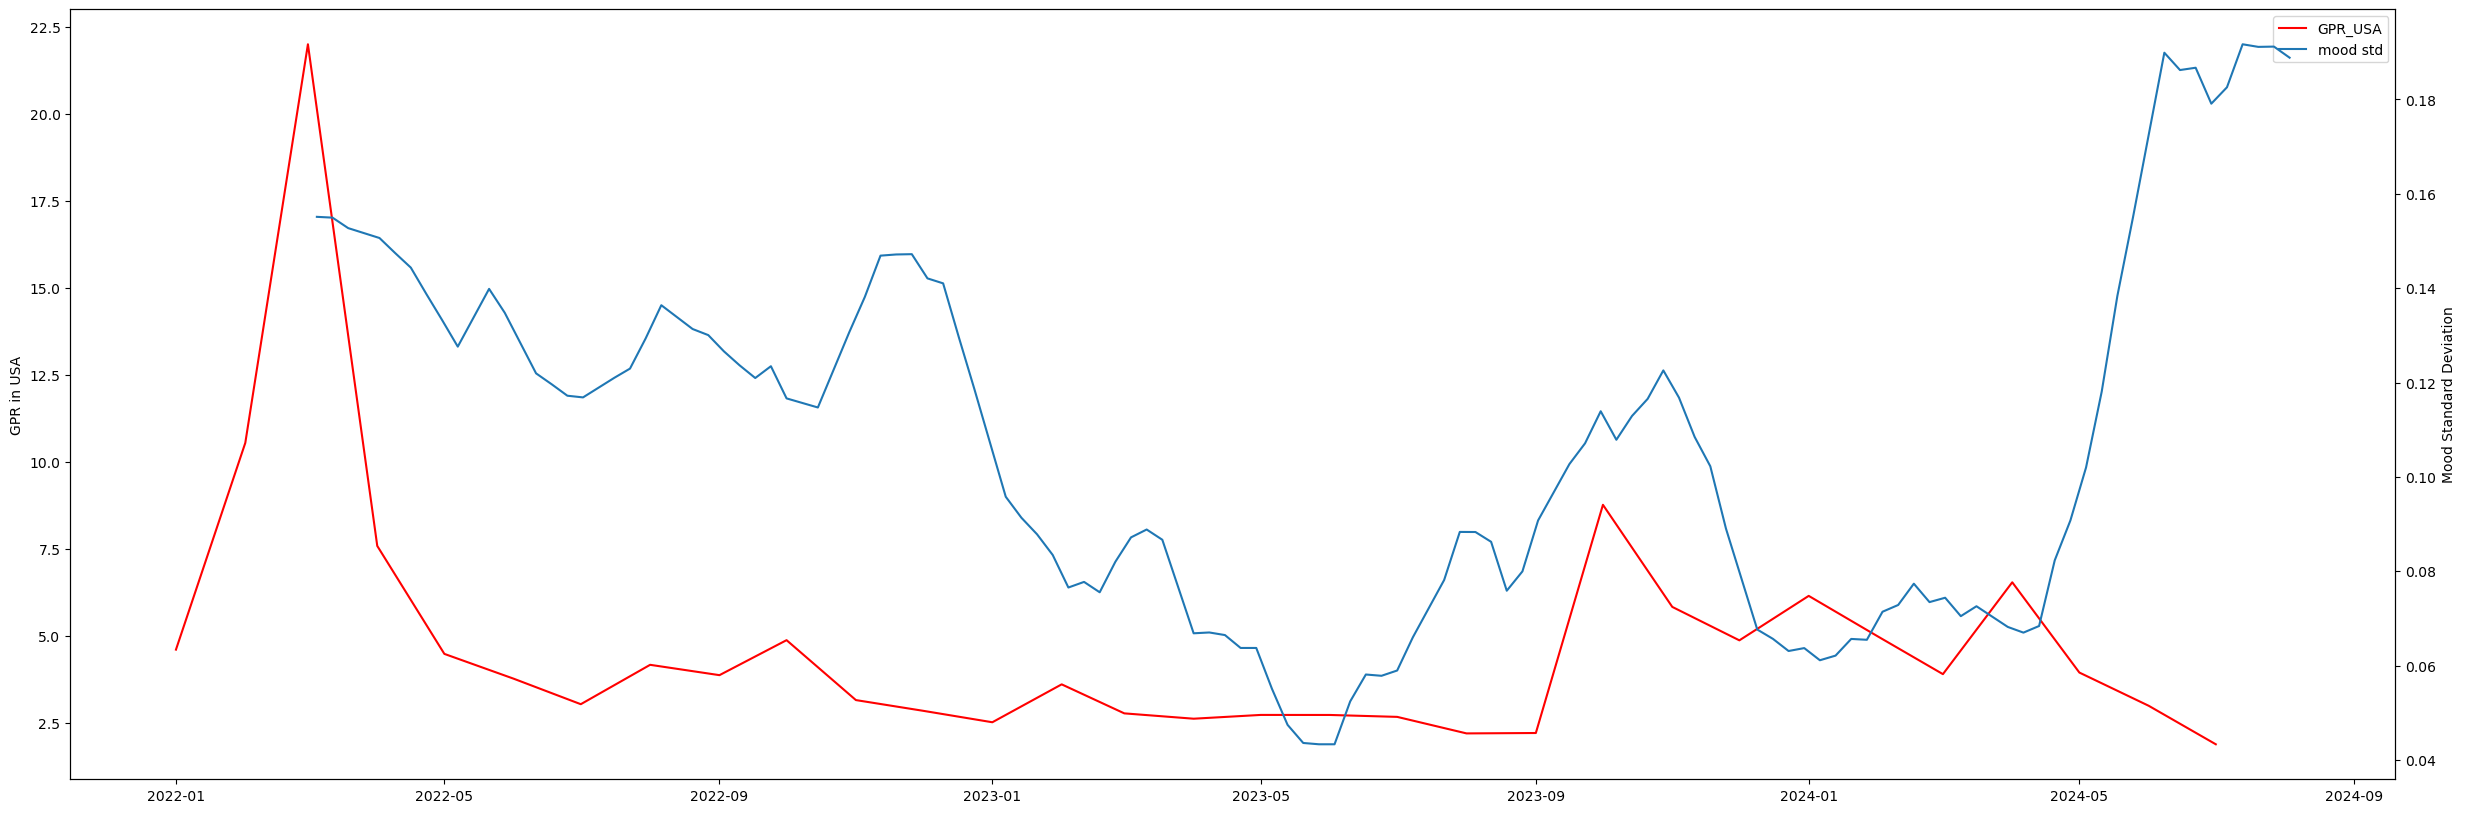

In [38]:
data = top_3_dfs.groupby("chart_week")["mood"].agg(["std"])

window_size = 10
smoothed_data = data.rolling(window=window_size).mean()

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(111)
line_1 = ax1.plot(monthly_gpr_df.index, monthly_gpr_df["GPR_USA"], "-r", label="GPR_USA")
ax2 = ax1.twinx()
line_2 = ax2.plot(smoothed_data.index, smoothed_data["std"], label="mood std")

lns = line_1+line_2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_ylabel("GPR in USA")
ax2.set_ylabel("Mood Standard Deviation")

plt.show()

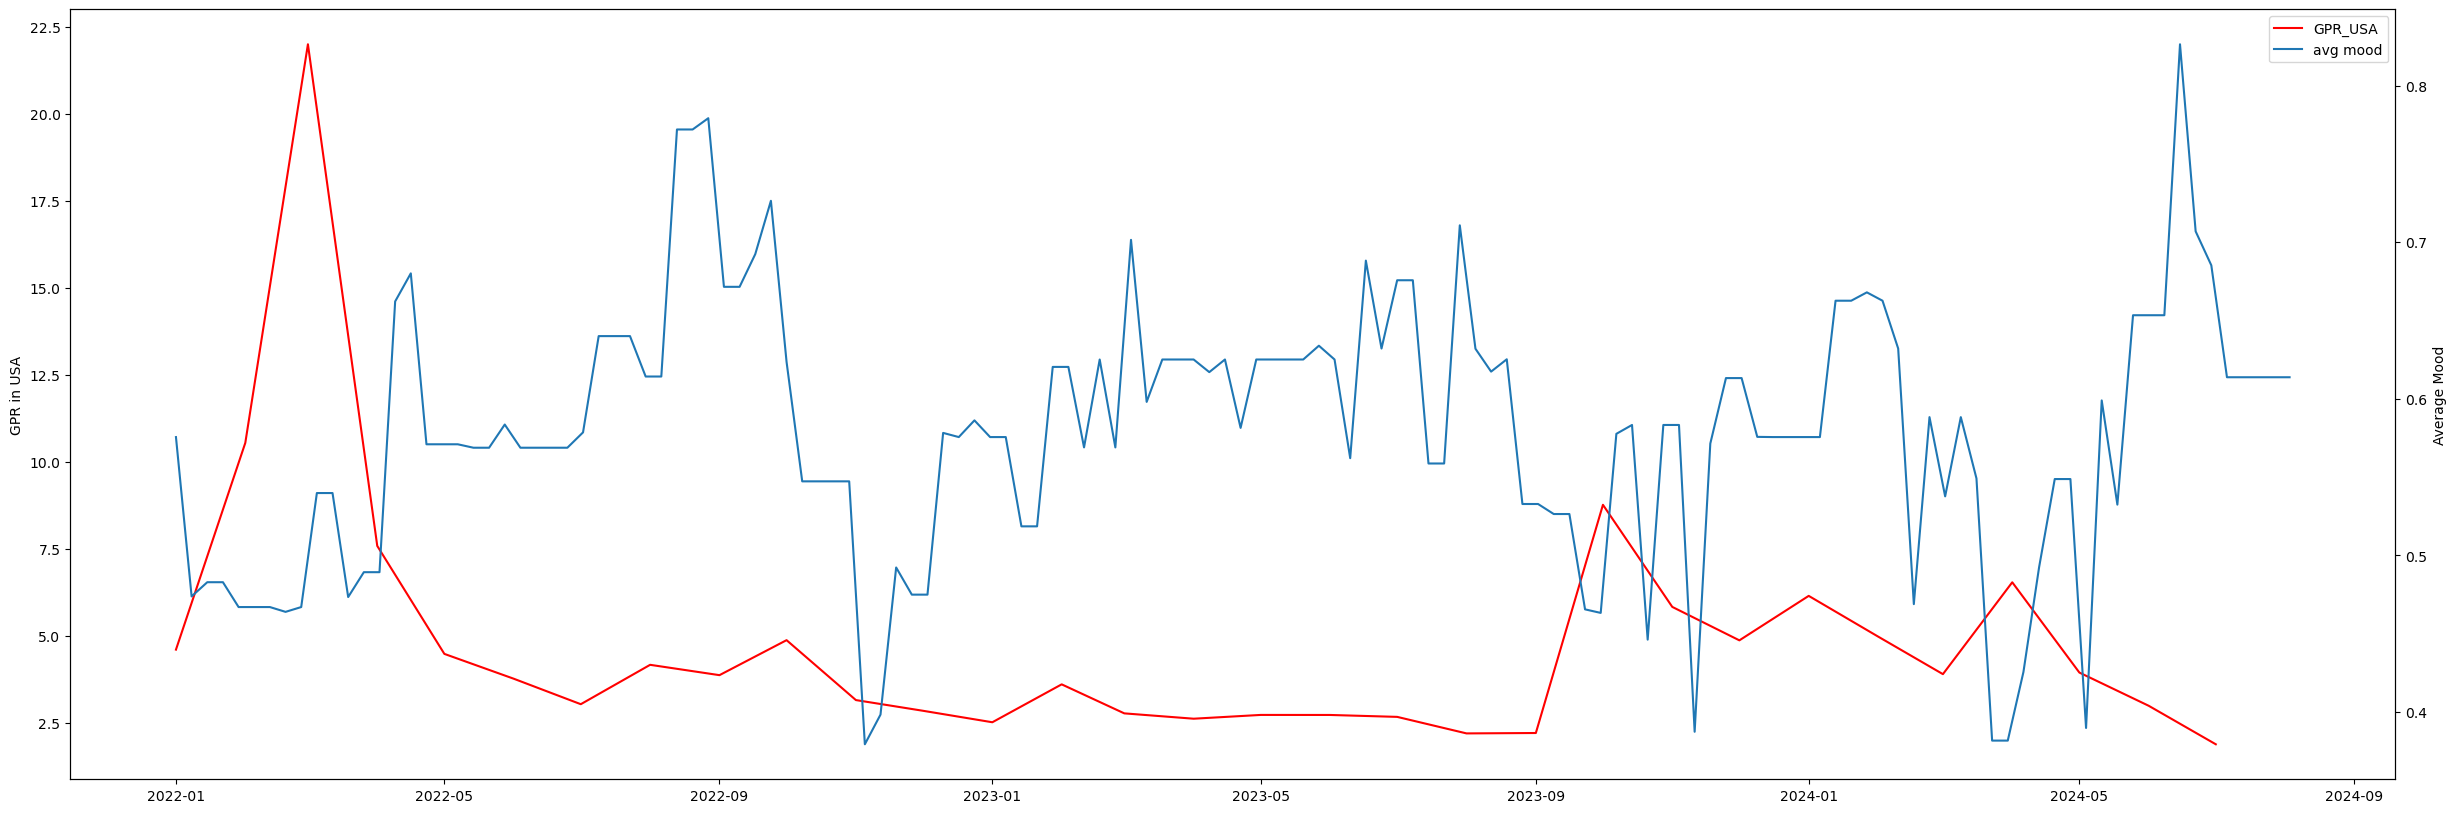

In [39]:
data = top_3_dfs.groupby("chart_week")["mood"].agg(["mean"])

window_size = 1
smoothed_data = data.rolling(window=window_size).mean()

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(111)
line_1 = ax1.plot(monthly_gpr_df.index, monthly_gpr_df["GPR_USA"], "-r", label="GPR_USA")
ax2 = ax1.twinx()
line_2 = ax2.plot(smoothed_data.index, smoothed_data["mean"], label="avg mood")

lns = line_1+line_2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)

ax1.set_ylabel("GPR in USA")
ax2.set_ylabel("Average Mood")

plt.show()

In [40]:
# Events:

In [41]:
# Import Events Timeline 
events = pd.read_csv('events_data.csv')
events = events.rename(columns ={'Unnamed: 0' : 'date'})
events['date'] = pd.to_datetime(events['date'])
events.head()

,date,Event,Category
0,2022-01-27,The Northeast experiences a major blizzard whi...,Weather
1,2022-02-01,February 2022 North American winter storm: A m...,Weather
2,2022-02-03,"The share price of Meta falls by 26.4%, with F...",Economic
3,2022-02-24,"President Biden announces new, stronger sancti...",Political
4,2022-02-26,President Biden signs an order to provide $600...,Political


In [42]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      135 non-null    datetime64[ns]
 1   Event     135 non-null    object        
 2   Category  135 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 3.3+ KB
